In [1]:
#-*- coding : utf-8 -*-
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
from stMMR.utils import *
from stMMR.process import *
from stMMR import train_model


In [2]:
sections_ids = [151673,151674,151675,151676]
k=7
adatalist = []
adjlist = []

In [3]:
for section_id in sections_ids:
    section_id = str(section_id)
    im_re = pd.read_csv(os.path.join('../Data/DLPFC/',section_id, "image_representation/ViT_pca_representation.csv"),
                        header=0, index_col=0,sep=',')
    print(section_id, k)
    input_dir = os.path.join('../Data/DLPFC/', section_id)
    adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')
    adata.var_names_make_unique()

    adata.obsm["spatial"][:, 1] *= -1
    adata.obs['section_id'] = section_id
    adj = calculate_adj_matrix(adata)
    adjlist.append(adj)

    adatalist.append(adata)
    adata.obsm["im_re"] = im_re

    Ann_df = pd.read_csv(os.path.join('../Data/DLPFC/',
                                      section_id, "cluster_labels_" + section_id + '.csv'), sep=',', header=0,
                         index_col=0)
    adata.obs['ground_truth'] = Ann_df.loc[adata.obs_names, 'ground_truth']

    Ann_df = Ann_df.replace(1, "Layer 1")
    Ann_df = Ann_df.replace(2, "Layer 2")
    Ann_df = Ann_df.replace(3, "Layer 3")
    Ann_df = Ann_df.replace(4, "Layer 4")
    Ann_df = Ann_df.replace(5, "Layer 5")
    Ann_df = Ann_df.replace(6, "Layer 6")
    Ann_df = Ann_df.replace(7, "WM")
    adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'ground_truth']

151673 7
151674 7
151675 7
151676 7


In [4]:
combined_adata = sc.concat(adatalist, join='outer', index_unique=None)
sc.pp.highly_variable_genes(combined_adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_per_cell(combined_adata)
sc.pp.log1p(combined_adata)

In [5]:
combined_adata= train_model.train_mul(combined_adata,adjlist,k,n_epochs=300,h=[3000,3000],
                                      enhancement=False,radius=0,l=2,a=100)

[2024-10-01 00:04:57] Epoch: 0/300, Loss: 84.2168
[2024-10-01 00:06:21] Epoch: 5/300, Loss: 63.1241
[2024-10-01 00:07:44] Epoch: 10/300, Loss: 48.1255
[2024-10-01 00:09:06] Epoch: 15/300, Loss: 39.1428
[2024-10-01 00:10:29] Epoch: 20/300, Loss: 34.7266
[2024-10-01 00:11:49] Epoch: 25/300, Loss: 31.1727
[2024-10-01 00:13:08] Epoch: 30/300, Loss: 29.7602
[2024-10-01 00:14:26] Epoch: 35/300, Loss: 28.9793
[2024-10-01 00:15:45] Epoch: 40/300, Loss: 28.5242
[2024-10-01 00:17:05] Epoch: 45/300, Loss: 28.1967
[2024-10-01 00:18:26] Epoch: 50/300, Loss: 27.9572
[2024-10-01 00:20:05] Epoch: 55/300, Loss: 27.7686
[2024-10-01 00:21:50] Epoch: 60/300, Loss: 27.6171
[2024-10-01 00:23:26] Epoch: 65/300, Loss: 27.4937
[2024-10-01 00:24:53] Epoch: 70/300, Loss: 27.3977
[2024-10-01 00:26:16] Epoch: 75/300, Loss: 27.2996
[2024-10-01 00:27:40] Epoch: 80/300, Loss: 27.2121
[2024-10-01 00:29:02] Epoch: 85/300, Loss: 27.1343
[2024-10-01 00:30:23] Epoch: 90/300, Loss: 27.0681
[2024-10-01 00:31:45] Epoch: 95/3

In [6]:
obs_df = combined_adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['stMMR'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' % ARI)

Adjusted rand index = 0.59


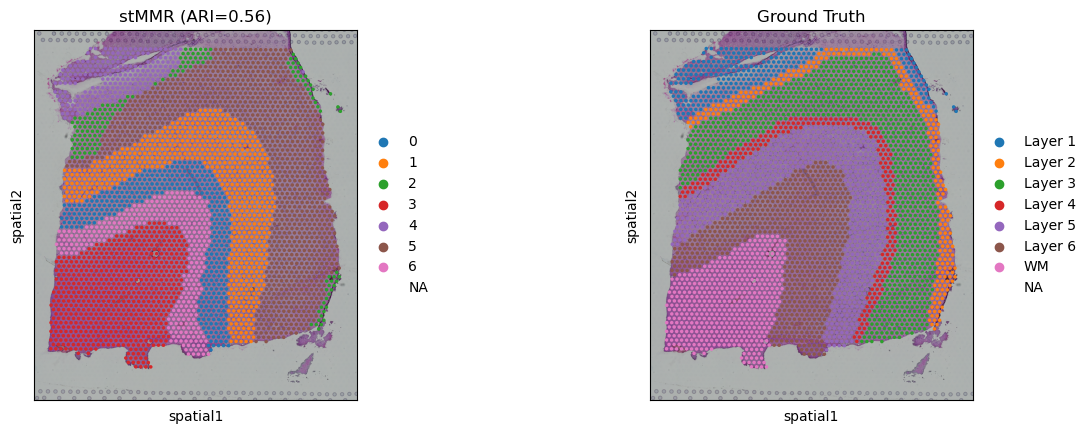

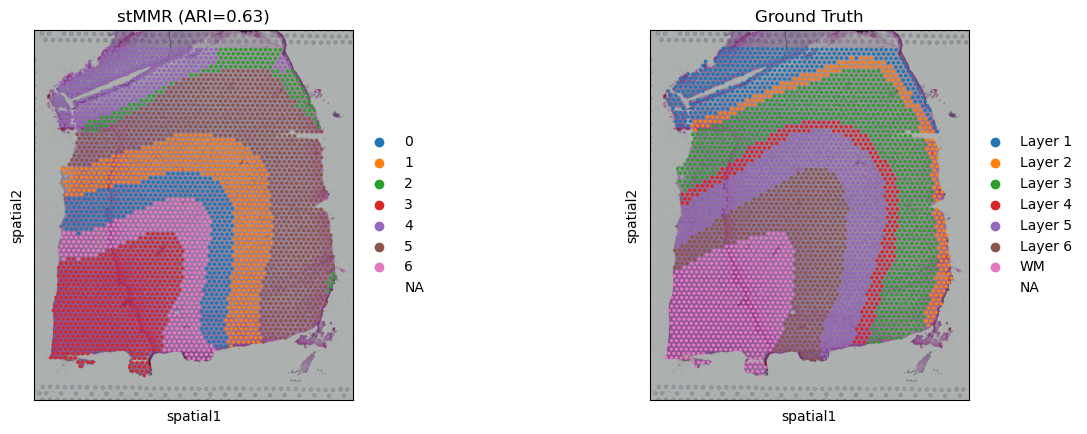

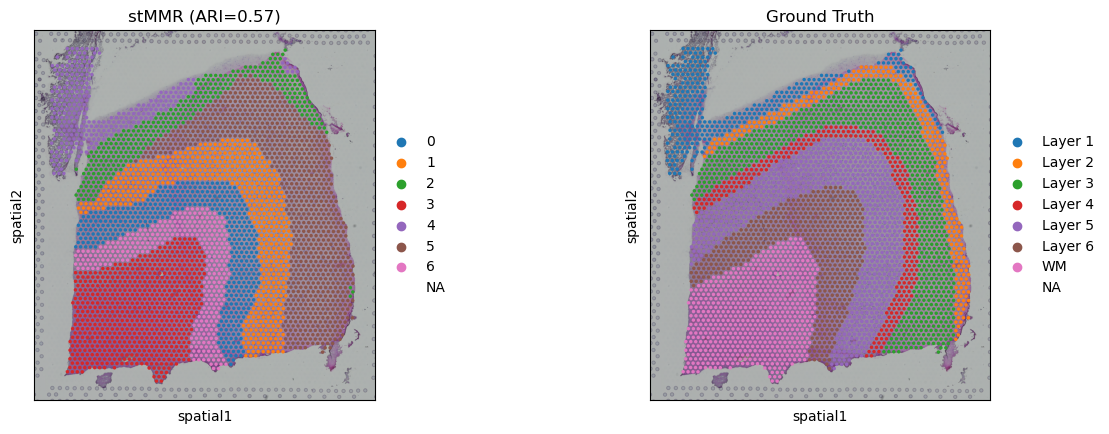

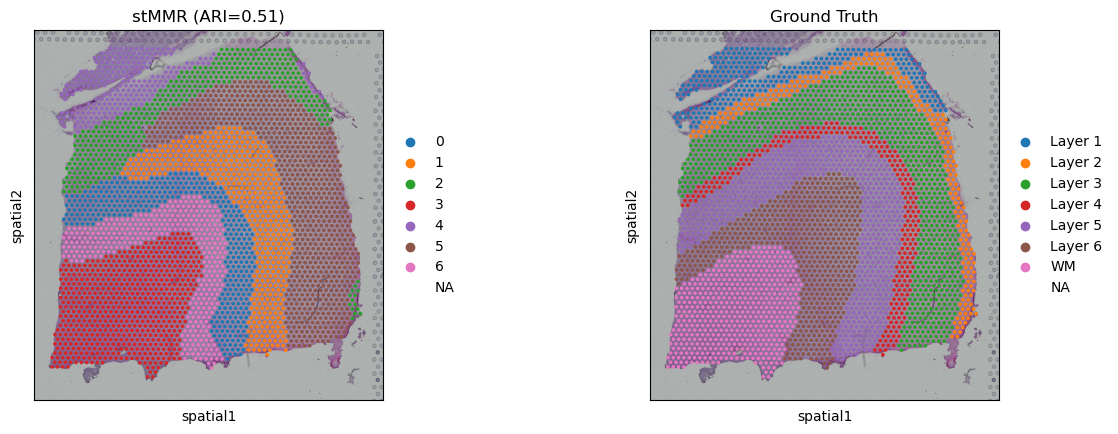

In [7]:
for section_id in sections_ids:
    adata = combined_adata[combined_adata.obs['section_id'] == str(section_id)].copy()
    nearest_new_type = refine_label(adata, radius=50,key='cluster')
    adata.obs["stMMR"] = nearest_new_type
    obs_df =adata.obs.dropna()
    ARI = adjusted_rand_score(obs_df['stMMR'], obs_df['Ground Truth'])
    input_dir = os.path.join('../Data/DLPFC/', str(section_id))
    adatat = sc.read_visium(path=input_dir, count_file=str(section_id)+'_filtered_feature_bc_matrix.h5')
    adatat.var_names_make_unique()

    adatat.obs["Ground Truth"] =  obs_df["Ground Truth"]
    adatat.obs["stMMR"] = obs_df["stMMR"]

    sc.pl.spatial(adatat, color=["stMMR", "Ground Truth"], title=['stMMR (ARI=%.2f)' % ARI, "Ground Truth"],
                  save="mutil"+ str(section_id))